<a href="https://colab.research.google.com/github/vubanc/BikeTimeSeriesAnalysis/blob/main/LSTM_TSForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM Time Series Forecasting**

In this notebook a PyTorch-based LSTM model was used to perform time series forecasting of bike trips for a bikesharing program in Fort Smith, Arkansas. The data was collected between the months of May 2022 and August 2023. Time series forecasting was performed on monthly as well as daily levels. The notebook will be updated as new data is collected.

### **Importing Libraries and Datasets**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [110]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

!pip install ray
from ray import tune

In [234]:
df = pd.read_csv("/content/drive/MyDrive/Work/Bikesharing/CombinedRentals_AllStations.csv")
df.head(2)

,index,id,user,user_id,user_phone,start_station,start_time,start_time_local,end_station,end_time,end_time_local,kilometers,miles,message_count,type,duration (seconds),rating,device_id,bike_type,Date
0,1,34ac1576-891f-4aca-a570-31db6160fd6f,Dara Ochoa,2112677d-b644-4cb8-866d-58f52b932f76,14792852353,Riverfront Park,2023-08-02 01:09:31.952446+00:00,2023-08-01 19:09:31.952446-06:00,Riverfront Park,2023-08-02 01:10:19.952446+00:00,2023-08-01 19:10:19.952446-06:00,NaN,NaN,130,22,48.0,NaN,74164be4e769c0ff30f08acb19724fa186d89b71913e9b...,Regular Bike,2023-08-01
1,2,dc96b3e6-f607-452b-ad18-79ea96e033d9,Gervon Pennington,79ea58b0-0988-47da-b963-a11a52a94f04,19035560048,Riverfront Park,2023-08-02 00:48:53.349677+00:00,2023-08-01 18:48:53.349677-06:00,Riverfront Park,2023-08-02 01:24:14.349677+00:00,2023-08-01 19:24:14.349677-06:00,4.482,2.78498,41,22,2121.0,NaN,fMV1Kdc8Km,Regular Bike,2023-08-01


### **EDA and Data Preprocesing**

In [235]:
#Data Manipulation (monthly trips)
df.rename(columns={"Date":"date"}, inplace=True)
df["month"] = pd.to_datetime(df["date"]).dt.strftime("%Y-%m")
df_monthlyTrips = df.groupby("month", as_index=False)["id"].count()
df_monthlyTrips.rename(columns={"id":"trip_count"}, inplace=True)
df_monthlyTrips.set_index("month", inplace=True)
df_monthlyTrips.head(2)

,trip_count
month,
2022-05,364
2022-06,316


In [236]:
#Data Manipulation (Daily)
min_date = df.date.min()
max_date = df.date.max()

dates = pd.DataFrame(pd.date_range(start=min_date, end=max_date))
dates.rename(columns={0:"date"}, inplace=True)
df["date"] = pd.to_datetime(df.date)
df = pd.merge(dates, df, how="left", on="date")
df_dailyTrips = pd.DataFrame(df.groupby("date", as_index=True)["id"].count())
df_dailyTrips.rename(columns={"id":"trip_count"}, inplace=True)
df_dailyTrips.head(2)

,trip_count
date,
2022-05-02,2
2022-05-03,14


<Axes: title={'center': 'Daily Trips'}, xlabel='trip_count'>

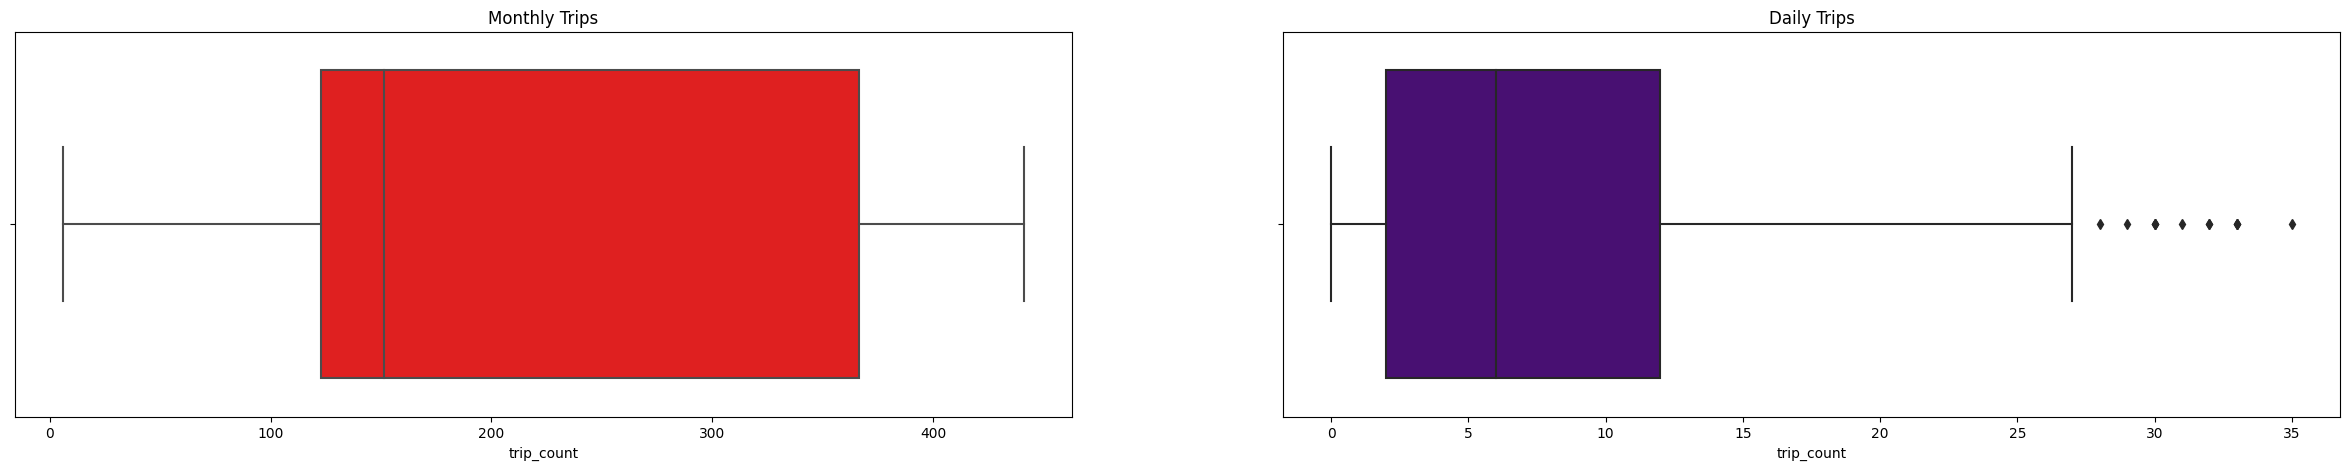

In [237]:
#Distribution of monthly and daily trips
fig, axs = plt.subplots(1,2, figsize=(30,5))
axs[0].set_title("Monthly Trips")
axs[1].set_title("Daily Trips")
sns.boxplot(df_monthlyTrips, x="trip_count", color="red", ax=axs[0])
sns.boxplot(df_dailyTrips, x="trip_count", color="indigo", ax=axs[1])

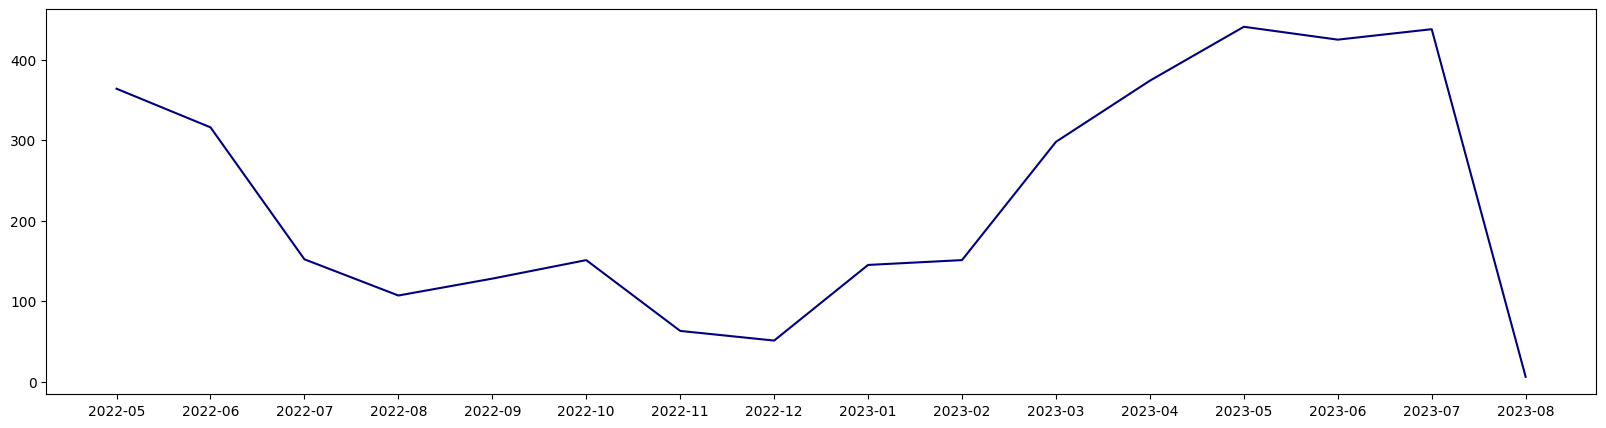

In [238]:
#Monthly Trend
fig, axs = plt.subplots(1,1, figsize=(20,5))
plt.plot(df_monthlyTrips['trip_count'], color="navy")

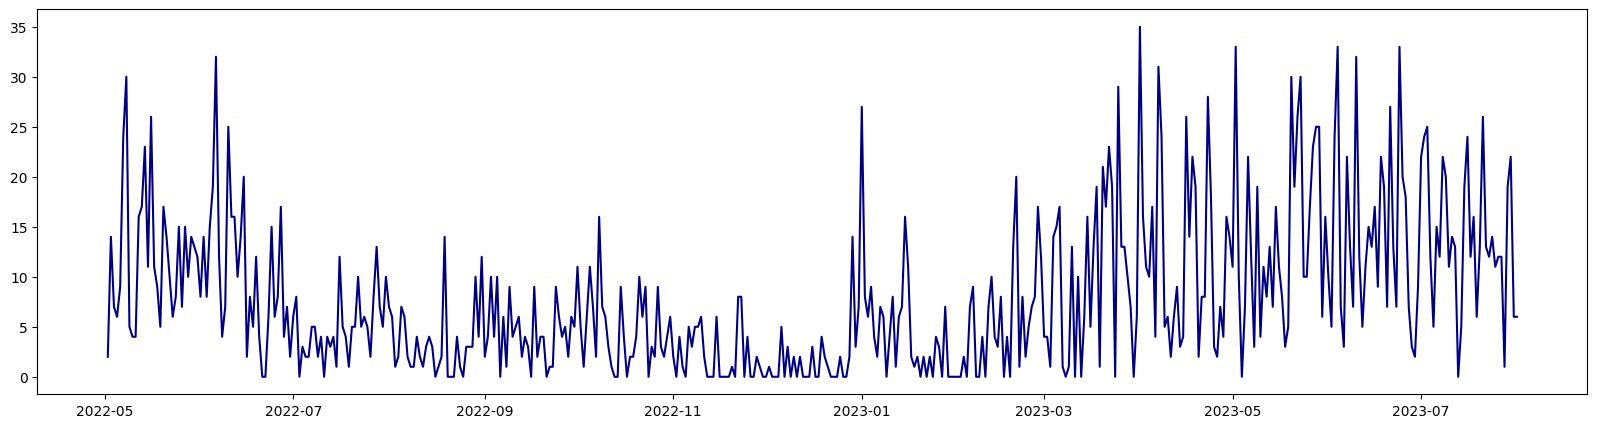

In [239]:
#Daily Trend
fig, axs = plt.subplots(1,1, figsize=(20,5))
plt.plot(df_dailyTrips['trip_count'], color="navy")

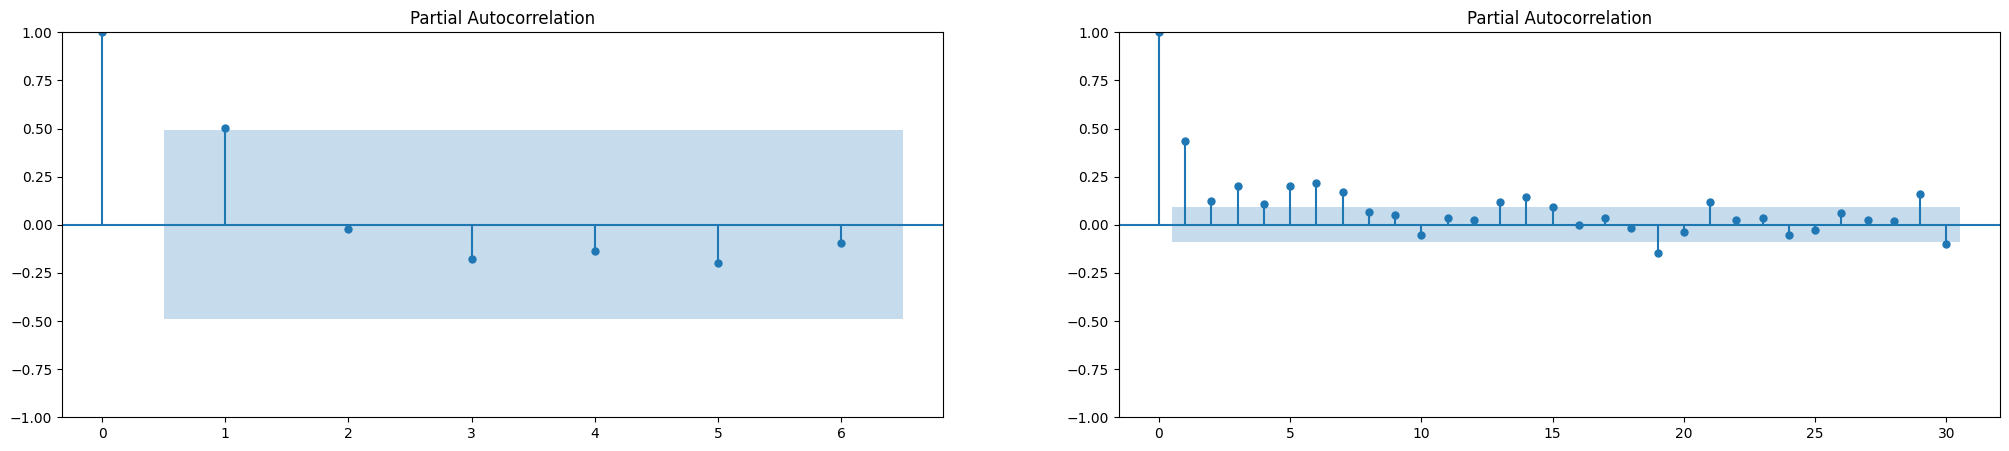

In [240]:
#Partial autocorrelation (monthly and daily)
fig, axs = plt.subplots(1,2, figsize=(25,5))

plot_pacf(df_monthlyTrips, ax=axs[0], lags=6)
plot_pacf(df_dailyTrips, ax=axs[1], lags=30)

plt.show()

### **Feature Engineering**

In [241]:
#Creating LSTM input features with 7 lags
df_dailyTrips["trip_count"] = df_dailyTrips["trip_count"].astype(int)
df_dailyTrips["t-1"] = df_dailyTrips.trip_count.shift(1)
df_dailyTrips["t-2"] = df_dailyTrips.trip_count.shift(2)
df_dailyTrips["t-3"] = df_dailyTrips.trip_count.shift(3)
df_dailyTrips["t-4"] = df_dailyTrips.trip_count.shift(4)
df_dailyTrips["t-5"] = df_dailyTrips.trip_count.shift(5)
df_dailyTrips["t-6"] = df_dailyTrips.trip_count.shift(6)
df_dailyTrips["t-7"] = df_dailyTrips.trip_count.shift(7)

df_dailyTrips = df_dailyTrips[["t-7", "t-6", "t-5", "t-4", "t-3", "t-2", "t-1", "trip_count"]]
df_dailyTrips = df_dailyTrips[df_dailyTrips.index.strftime("%Y-%m-%d")>="2022-05-09"].astype(int)
df_dailyTrips.head(10)

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,trip_count
date,,,,,,,,
2022-05-09,2,14,7,6,9,24,30,5
2022-05-10,14,7,6,9,24,30,5,4
2022-05-11,7,6,9,24,30,5,4,4
2022-05-12,6,9,24,30,5,4,4,16
2022-05-13,9,24,30,5,4,4,16,17
2022-05-14,24,30,5,4,4,16,17,23
2022-05-15,30,5,4,4,16,17,23,11
2022-05-16,5,4,4,16,17,23,11,26
2022-05-17,4,4,16,17,23,11,26,11


In [242]:
#Converting features and labels to numpy arrays to be fed into TensorDataset function
features = np.array(df_dailyTrips[["t-7", "t-6", "t-5", "t-4", "t-3", "t-2", "t-1"]])
labels = np.array(df_dailyTrips[["trip_count"]])
print(f"features shape: {features.shape}, labels shape: {labels.shape}")

features shape: (450, 7), labels shape: (450, 1)


In [243]:
#Checking the mean and standard deviation of the input features to see if scaling is necessary
print(f"Mean: {np.mean(features, axis=0)}")
print(f"Standard Deviation: {np.std(features, axis=0)}")
print(f"Inter-quartile Range: {np.percentile(features, 75, axis=0)-np.percentile(features, 25, axis=0)}")

Mean: [7.84888889 7.87111111 7.86666667 7.85333333 7.88222222 7.91111111
 7.87111111]
Standard Deviation: [7.66082741 7.65833235 7.65535397 7.66207399 7.67951934 7.70806856
 7.67108922]
Inter-quartile Range: [10. 10. 10. 10. 10. 10. 10.]


The descriptive statistics suggest that scaling is not necessary for the dataset.

Helper Functions

In [244]:
#Splitting training, validation, and testing data for action labels only
def data_splitter(features, labels):
  split_frac = 0.8
  train_x = features[0:int(split_frac*len(features))]
  train_y = labels[0:int(split_frac*len(features))]
  remaining_x = features[int(split_frac*len(features)):]
  remaining_y = labels[int(split_frac*len(features)):]
  valid_x = remaining_x[0:int(len(remaining_x)*0.75)]
  valid_y = remaining_y[0:int(len(remaining_y)*0.75)]
  test_x = remaining_x[int(len(remaining_x)*0.75):]
  test_y = remaining_y[int(len(remaining_y)*0.75):]

  return train_x, train_y, valid_x, valid_y, test_x, test_y

In [245]:
def data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y, batch_size):
  train_data = TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float())
  valid_data = TensorDataset(torch.from_numpy(valid_x).float(), torch.from_numpy(valid_y).float())
  test_data = TensorDataset(torch.from_numpy(test_x).float(), torch.from_numpy(test_y).float())

  train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
  valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
  test_loader = DataLoader(test_data, shuffle=False, batch_size=len(test_data))

  return train_loader, valid_loader, test_loader

### **LSTM Class**

In [252]:
class LSTM(nn.Module):

  def __init__(self, input_size, hidden_size, output_size, num_layers, batch_size, loss, learning_rate, dropout=0.4):
    super(LSTM, self).__init__()
    self.num_layers, self.batch_size, self.hidden_size = num_layers, batch_size, hidden_size
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bias=True, batch_first=True, dropout=dropout)
    self.dropout = nn.Dropout(p=0.4)
    self.fc = nn.Linear(hidden_size, output_size) #This layer is just going to convert the hidden state of size n>=1 to output of size 1

    if loss=="MSELoss":
      self.loss = nn.MSELoss()
    elif loss=="HuberLoss":
      self.loss = nn.HuberLoss()
    elif loss=="SmoothL1Loss":
      self.loss = nn.SmoothL1Loss()

    self.optimizer = torch.optim.Adam(params=self.parameters(), lr=learning_rate)

  def init_hiddens(self, batch_size):
    weights = next(self.parameters()).data
    hiddens = (weights.new(self.num_layers, batch_size, self.hidden_size).zero_(),
              weights.new(self.num_layers, batch_size, self.hidden_size).zero_())
    return hiddens

  def forward(self, hiddens, inputs):
    batch_size = inputs.size(0)

    outputs, hn = self.lstm(inputs, hiddens) # outputs -> [batch_size, sequence_length, hidden_size]
    outputs = outputs.contiguous().view(-1, self.hidden_size) # outputs -> [batch_size*seq_length, hidden_size]
    outputs = self.dropout(outputs)
    outputs = self.fc(outputs) # outputs -> [batch_size*seq_length, 1]

    outputs = outputs.view(batch_size, -1) # outputs -> [batch_size, seq_length]
    outputs = outputs[:,-1] # outputs -> [batch_size, 1]
    return outputs, hn

  def train(self, train_loader, valid_loader, epochs):
    for epoch in range(epochs):
      for i, (features, labels) in enumerate(train_loader):
        batch_size = features.size(0)
        hiddens = self.init_hiddens(batch_size)
        outputs, _ = self.forward(hiddens, features.unsqueeze(2))
        loss = self.loss(outputs.squeeze(), labels.float())

        self.optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(self.parameters(), 5)
        self.optimizer.step()

        if (epoch+1)%100==0:
            total_valid_loss = []
            for j,(valid_features, valid_labels) in enumerate(valid_loader):
              batch_size = valid_features.size(0)
              hiddens = self.init_hiddens(batch_size)
              valid_outputs,_ = self.forward(hiddens, valid_features.unsqueeze(2))
              valid_loss = self.loss(valid_outputs.squeeze(), valid_labels.float())
              total_valid_loss.append(valid_loss.item())

            print(f"Epoch: {epoch+1} | step:{i} | training loss: {loss} | validation loss: {np.mean(total_valid_loss)}")
    print("Training Complete!")

  def test(self, test_loader):
    test_losses = []
    all_predictions = []

    with torch.no_grad():
      for features, labels in test_loader: #This will be only one iteration since test_laoder has only one batch
        batch_size = features.size(0)
        hiddens = self.init_hiddens(batch_size)
        outputs, hiddens = self.forward(hiddens, features.unsqueeze(2))
        loss = self.loss(labels.float(), outputs.squeeze())
        test_losses.append(loss.item())

        predictions = torch.round(outputs.squeeze()).numpy() #Rounding off to nearest integer makes it binary
        all_predictions += predictions.tolist()

      loss = np.mean(test_losses)
      print(f"Test loss: {loss}")

    return all_predictions, loss

## **Training**

In [248]:
train_x, train_y, valid_x, valid_y, test_x, test_y = data_splitter(features, labels)
train_loader, valid_loader, test_loader = data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y, 30)

In [253]:
model = LSTM(1, 4, 1, 2, 30, 'MSELoss', 0.01)
model

LSTM(
  (lstm): LSTM(1, 4, num_layers=2, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=4, out_features=1, bias=True)
  (loss): MSELoss()
)

In [ ]:
model.train(train_loader, valid_loader, 1000)

### **Hyperparameter Optimization**

In [270]:
def LstmOptimizer(config):
  train_loader, valid_loader, test_loader = data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y, config["batch_size"])
  model = LSTM(1, config["hidden_size"], 1, config["num_layers"], config["batch_size"], config["loss"], config["lr"]) #input_size, hidden_size, output_size, num_layers, batch_size, loss, learning_rate, dropout
  model.train(train_loader, valid_loader, config["epochs"])
  predictions, loss = model.test(test_loader)
  tune.report(loss=loss)

In [271]:
config={"epochs":tune.choice([500,1000,2000,3000,4000,5000]),
        "hidden_size": tune.grid_search([4]),
        "batch_size":tune.choice([5,10,20,40,80,160]),
        "lr": tune.loguniform(0.001, 0.05),
        "loss":tune.grid_search(["MSELoss"]),
        "num_layers":tune.grid_search([1])}

In [ ]:
analysis = tune.run(LstmOptimizer, config=config)

2023-08-12 03:52:57,696	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-08-12 03:52:57,718	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+----------------------------------------------------------------------+
| Configuration for experiment     LstmOptimizer_2023-08-12_03-52-57   |
+----------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator               |
| Scheduler                        FIFOScheduler                       |
| Number of trials                 1                                   |
+----------------------------------------------------------------------+

View detailed results here: /root/ray_results/LstmOptimizer_2023-08-12_03-52-57

Trial status: 1 PENDING
Current time: 2023-08-12 03:52:57. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------+
| Trial name                  status       epochs     batch_size          lr     hidden_size   loss        num_layers |
+-----------------------------------------

In [225]:
analysis.get_best_config(metric="r2score", mode="min")

{'lr': 0.01}

### **Experimental Code**

In [212]:
predictions, r2score = model.test(test_loader)

Test loss: 83.95713806152344


In [213]:
r2score

-0.9883319797713375

In [94]:
print(f"Test RMSE: {np.sqrt(mean_squared_error(test_y, predictions))}")

Test RMSE: 10.77239269820983


In [165]:
for feature, labels in test_loader:
  print(r2_score(predictions, labels))

-45.27203192550717


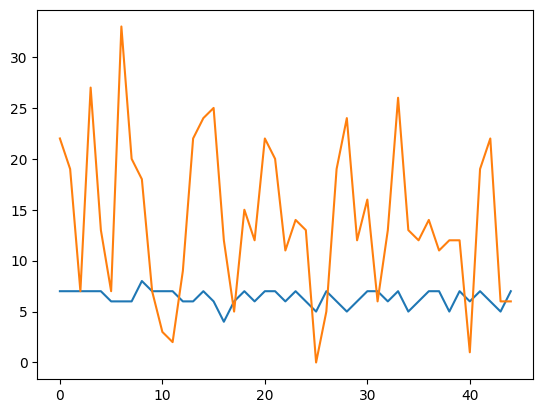

In [96]:
plt.plot(predictions)
plt.plot(test_y)

In [209]:
test_y.shape

(23, 1)